In [1]:
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd 
from os import listdir
from os.path import basename,join,exists
import os
print(listdir("../input"))
import threading
from queue import Queue
from math import floor
import time
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
# Any results you write to the current directory are saved as output.

['dog-breed-identification-mlbootcamp']


In [3]:
df = pd.read_csv('../input/dog-breed-identification-mlbootcamp/sample_submission.csv')
train_dir_path = "../input/dog-breed-identification-mlbootcamp/train"
test_dir_path = "../input/dog-breed-identification-mlbootcamp/test"
labels_df = pd.read_csv('../input/dog-breed-identification-mlbootcamp/labels.csv')
dog_breeds = list(df.columns[1:])
print(len(dog_breeds))
print(dog_breeds)

120
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', '

In [4]:
train_img_fpaths = [ join(train_dir_path, f) for f in listdir(train_dir_path)]
test_img_fpaths = [join(test_dir_path, f) for f in listdir(test_dir_path)]
print(len(train_img_fpaths))
print(len(test_img_fpaths))

10222
10357


In [5]:
def dog_breed_from_id(dog_id):
    #labels_df = pd.read_csv('../input/labels.csv')
    return labels_df[labels_df['id'] ==dog_id]['breed'].values

In [6]:
import cv2 as cv
import numpy as np

In [7]:
# variables 
IMG_HEIGHT = 150
IMG_WIDTH = 150
IMG_CHANNELS = 3
BATCH_SIZE = 500
lock = threading.Lock()

In [8]:
def img_to_array(img_path):   
    img_array = cv.imread(img_path)
    img_array = cv.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
    img_array = img_array.reshape(-1,IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS)
    return img_array

In [9]:
# initialize queue which is threadsafe 
def initialize_queue():
    queue =Queue()
    return queue

In [10]:
# get list of image ids from names of test images
def get_test_image_ids():
    return [basename(fpath).split('.')[0] for fpath in test_img_fpaths]

In [11]:
# converts image files to numpy array and based on train/test, return train array and labels,
def get_data(is_train):
    # 1 batch per thread and last thread with remaining images
    img_fpaths = train_img_fpaths if is_train else test_img_fpaths
    num_threads = floor(len(img_fpaths)/BATCH_SIZE)
    print("num of threads:", num_threads + 1)
    img_array = None
    queue = initialize_queue()
    results = []          # results from multiple threads
    print("getting training data....") if is_train else print("getting testing data....")
    
    # load queue with data for each task
    for batch_index in range(num_threads + 1):
        if batch_index == num_threads:
            file_batch = img_fpaths[(batch_index*BATCH_SIZE):]
        else:
            file_batch = img_fpaths[(batch_index*BATCH_SIZE) : (batch_index + 1)*BATCH_SIZE]
        queue.put(file_batch)
    
    # iterate over loop to create threads
    for thread_index in range(num_threads+1):
        thread = threading.Thread(target = get_train_data_parallely, args=(queue, results)) if is_train else threading.Thread(target =get_testing_data_parallely, args =(queue, results))    
        thread.start()
        print("{} started".format(thread.name))
       # worker_threads.append(thread)
        
    # when queue in empty
    queue.join()
    return results

In [12]:
# convert training data into list of tuples
# this subroutine represents a task for child thread to collect training data
def get_train_data_parallely(queue, results):
    result = []
    while not queue.empty():
        fpaths = queue.get()
        for f_path in fpaths:
            img_array = img_to_array(f_path)
            # train_img_array = img_array if train_img_array is None else np.vstack((train_img_array, img_array))
            img_name = basename(f_path)
            img_id = img_name.split('.')[0]
            dog_breed = dog_breed_from_id(img_id)
            #train_labels.append(dog_breed)
            results.append((img_array, dog_breed))
            
    # append arr,labels for current task to results
    print("{} finished".format(threading.currentThread().getName()))
    # signal for task has been done
    queue.task_done()

In [13]:
# worker job for converting test imgs to array
def get_testing_data_parallely(queue, results):
    while not queue.empty():
        file_batch = queue.get()
        for f_path in file_batch:        
            img_name = basename(f_path)
            img_id = img_name.split('.')[0]
            results.append((img_id, img_to_array(f_path)))
    print("{} finished".format(threading.currentThread().getName()))
    queue.task_done()

In [14]:
# method for getting training data
def get_training_data():
    train_results = get_data(is_train = True)
    train_labels = []
    img_arrays= []
    for u_index in range(len(train_results)):
        img_arr, identified_breed = train_results[u_index]
        img_arrays.append(img_arr)
        train_labels.append(identified_breed)
    train_arr = np.array(img_arrays).reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    train_arr = train_arr/255
    train_labels = one_hot_encode_labels(train_labels)
    return train_arr,train_labels

In [15]:
# method for getting testing arr
def get_testing_data():
    results = get_data(is_train = False)
    test_img_ids = []
    test_img_list = []
    for test_result in results:
        img_id, img_arr = test_result
        test_img_list.append(img_arr)
        test_img_ids.append(img_id)
    test_img_arr = np.array(test_img_list).reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    test_img_arr = test_img_arr/255
    return test_img_arr, test_img_ids

In [16]:
def save_obj_to_disk(fname, obj):
    print("saving "+ fname +" to filesystem")
    if  exists(fname):
        print(fname + "already exists") 
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)

In [17]:
def load_obj_from_disk(fname):
    if exists(fname):
        print("loading "+fname + " from filesystem")
        obj = None
        with open(fname, 'rb') as f:
            obj = pickle.load(f)
        return obj
    else:
        print(fname + "doesnt not exists")

In [18]:
def load_train_test_data(load_train=False, load_test=False, one_hot_encode=False):
    train_arr = None
    train_labels = None
    test_arr = None
    
    # check if training data and labels exists already as pickled file
    if load_train:
        if exists("train_data.pickle") and exists("train_labels.pickle"):
            train_arr = load_obj_from_disk("train_data.pickle")
            train_labels = load_obj_from_disk("train_labels.pickle")
            if one_hot_encode:
                train_labels = one_hot_encode_labels(train_labels)
        else:
            # create training_data and save it to filesystem
            train_arr, train_labels = get_data(is_train= True)
            if not exists("train_data.pickle"):
                save_obj_to_disk("train_data.pickle", train_data)
            if not exists("train_labels.pickle"):
                save_obj_to_disk("train_labels.pickle", train_labels)
        print(" train array shape : {}, train array labels: {}".format(train_data.shape,len(train_labels)))
        
    # check if testing data and labels exists already as pickled file
    if load_test:
        if exists("test_data.pickle"):
            test_arr = load_obj_from_disk("test_data.pickle")
        else:
            # create test_data and save it to filesystem
            test_arr = get_data(is_train= False)
            save_obj_to_disk("test_data.pickle", test_arr)
        print(" test array shape : {}".format(test_arr.shape))
    return train_arr, train_labels, test_arr

In [19]:
# method for onehot encoding labels of train_arr
def one_hot_encode_labels(label_arr):
    from sklearn.preprocessing import LabelEncoder ,OneHotEncoder
    labelEncoder = LabelEncoder()
    integer_encoded = labelEncoder.fit_transform(np.array(label_arr))
    integer_encoded = integer_encoded.reshape(-1,1)
    onehotEncoder = OneHotEncoder()
    onehot_encoded_arr = onehotEncoder.fit_transform(integer_encoded).toarray()
    return onehot_encoded_arr

In [20]:
train_x, train_y =get_training_data()

num of threads: 21
getting training data....
Thread-5 started
Thread-6 started
Thread-7 started
Thread-8 started
Thread-9 started
Thread-10 started
Thread-11 started
Thread-12 started
Thread-13 started
Thread-14 started
Thread-15 started
Thread-16 started
Thread-17 started
Thread-18 started
Thread-19 started
Thread-20 started
Thread-21 started
Thread-22 started
Thread-23 started
Thread-24 started
Thread-25 started
Thread-25 finished
Thread-18 finished
Thread-6 finished
Thread-5 finished
Thread-12 finished
Thread-15 finished
Thread-19 finished
Thread-8 finished
Thread-9 finished
Thread-23 finished
Thread-24 finished
Thread-11 finished
Thread-7 finished
Thread-10 finished
Thread-14 finished
Thread-13 finished
Thread-22 finished
Thread-21 finished
Thread-20 finished
Thread-17 finished
Thread-16 finished


In [21]:
test_x, test_img_ids = get_testing_data()

num of threads: 21
getting testing data....
Thread-26 started
Thread-27 started
Thread-28 started
Thread-29 started
Thread-30 started
Thread-31 started
Thread-32 started
Thread-33 started
Thread-34 started
Thread-35 started
Thread-36 started
Thread-37 started
Thread-38 started
Thread-39 started
Thread-40 started
Thread-41 started
Thread-42 started
Thread-43 started
Thread-44 started
Thread-45 started
Thread-46 started
Thread-46 finished
Thread-26 finished
Thread-27 finished
Thread-36 finished
Thread-41 finished
Thread-38 finished
Thread-34 finished
Thread-31 finished
Thread-39 finished
Thread-28 finished
Thread-32 finished
Thread-35 finished
Thread-40 finished
Thread-44 finished
Thread-30 finished
Thread-29 finished
Thread-33 finished
Thread-43 finished
Thread-45 finished
Thread-37 finished
Thread-42 finished


In [22]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(len(test_img_ids))

(10222, 150, 150, 3)
(10222, 120)
(10357, 150, 150, 3)
10357


In [23]:
# import required packages
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [24]:
# CNN model
model = Sequential()

# -----------------------------------------------------------------------------------
# conv 1
model.add(Conv2D(16, (3,3), input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))       # input -N,150,150,3, output- N,148,148,16
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

# max pool 1
model.add(MaxPooling2D(pool_size=(2,2),strides=2))                                   #input- N,148,148,16, output- N, 74,74,16

# -----------------------------------------------------------------------------------
# # conv 2
model.add(Conv2D(32, (3,3)))                                                         #input- N,74,74,16 output - N, 72,72,16
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

# max pool 2
model.add(MaxPooling2D(pool_size=(2,2),strides=2))                                 #input - N,72,72,16, output- N,36,36,16
# -----------------------------------------------------------------------------------

# conv 3
model.add(Conv2D(48, (3,3)))                                                       #input - N,36,36,16, output- N,34,34,32
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.7))

# max pool 3
model.add(MaxPooling2D(pool_size=(2,2),strides=2))                                #input- N,34,34,32, output- N,17,17,32
# -----------------------------------------------------------------------------------

# # conv 4
model.add(Conv2D(64, (3,3)))                                                     #input- N,17,17,32, output- N,15,15,32
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.7))
# max pool 4
model.add(MaxPooling2D(pool_size=(2,2),strides=2))                              #input- N,15,15,32, output- N,7,7,32

# flatten
model.add(Flatten())                                                            # output- 1568

# fc layer 1
model.add(Dense(1024, activation='relu'))                                  

# fc layer 2
model.add(Dense(512, activation='relu'))

# fc layer 3
model.add(Dense(256, activation='relu'))

# fc layer 4
model.add(Dense(120, activation='softmax'))

2022-11-07 22:59:23.712752: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 148, 148, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0

In [26]:
# compile model for with softmax cross entropy and adam optimizer, set accuracy as parameter to evaluate
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
# train model on training data
model_hist = model.fit(train_x, train_y, batch_size=32, epochs=20, verbose=1)

2022-11-07 22:59:25.929138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
320/320 [==============================] - 56s 171ms/step - loss: 4.7148 - accuracy: 0.0214
Epoch 2/20
320/320 [==============================] - 52s 164ms/step - loss: 4.4019 - accuracy: 0.0414
Epoch 3/20
320/320 [==============================] - 52s 163ms/step - loss: 4.2056 - accuracy: 0.0542
Epoch 4/20
320/320 [==============================] - 52s 164ms/step - loss: 4.0240 - accuracy: 0.0776
Epoch 5/20
320/320 [==============================] - 52s 163ms/step - loss: 3.8560 - accuracy: 0.0975
Epoch 6/20
320/320 [==============================] - 52s 161ms/step - loss: 3.6708 - accuracy: 0.1201
Epoch 7/20
320/320 [==============================] - 52s 163ms/step - loss: 3.4765 - accuracy: 0.1516
Epoch 8/20
320/320 [==============================] - 52s 163ms/step - loss: 3.2836 - accuracy: 0.1852
Epoch 9/20
320/320 [==============================] - 52s 163ms/step - loss: 3.0452 - accuracy: 0.2257
Epoch 10/20
320/320 [==============================] - 53s 164ms/step - l

In [28]:
predictions = model.predict(test_x, batch_size=32, verbose=1)

324/324 [==============================] - 17s 51ms/step


In [29]:
print(predictions.shape)
print(len(dog_breeds))

(10357, 120)
120


In [30]:
import pandas as pd
submission_res = pd.DataFrame(data= predictions, index =test_img_ids, columns= dog_breeds)
submission_res.index.name = 'id'
submission_res.to_csv('submission.csv', encoding='utf-8', index=True)
submission_data = pd.read_csv('submission.csv')
submission_data

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,2.839192e-09,3.451655e-04,2.753675e-03,3.877028e-07,8.984754e-06,3.020998e-15,8.416278e-07,1.307453e-06,9.597786e-07,...,3.589998e-06,2.492839e-07,3.069149e-09,7.086798e-07,2.596388e-03,1.226619e-05,1.131287e-05,2.999909e-02,1.451220e-04,1.997639e-07
1,56eef5133aeac23ce93a07e43be7d22f,2.412674e-14,2.326727e-12,1.830225e-10,2.218899e-07,7.018526e-14,3.813891e-18,5.663180e-03,1.462709e-09,2.483815e-07,...,9.356164e-07,1.855845e-06,9.745362e-09,1.103746e-10,1.175196e-07,1.321511e-08,1.092664e-19,1.123342e-08,9.896335e-13,8.559925e-03
2,d6487ec0c82b85e4db6e9b57a69b7587,5.495641e-02,6.314468e-07,3.686154e-04,1.327258e-09,4.173014e-08,1.687474e-09,1.310165e-08,5.193287e-09,1.660111e-07,...,1.570099e-06,1.284374e-06,1.527514e-07,1.120431e-09,4.641067e-01,1.146493e-10,1.219507e-11,3.335257e-06,1.963244e-07,1.834938e-06
3,0eb22da796bce296261373cfc4f3c2c8,2.090162e-12,8.246293e-09,1.332261e-10,2.971562e-10,1.069892e-06,1.858152e-17,1.134135e-08,2.991833e-12,3.952737e-13,...,1.910920e-04,4.512136e-13,1.059952e-12,3.350451e-12,2.925991e-05,4.464807e-11,1.771437e-01,8.648353e-06,3.433820e-06,4.652510e-05
4,230a6fb01dffd20c3f51ac7261ed0c68,5.261115e-06,1.544125e-03,2.365612e-03,1.164066e-04,1.411720e-05,2.644368e-10,4.308083e-02,4.297225e-08,9.603519e-06,...,7.261063e-03,4.885868e-07,3.739473e-06,2.027906e-07,2.394093e-03,3.189786e-08,1.455230e-06,2.416667e-07,3.309084e-04,1.834862e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,3706f3983a0e8ad6772d343796ec8c06,1.002852e-09,1.420445e-08,1.539450e-06,1.072825e-09,3.598346e-05,1.873731e-06,1.785269e-13,2.711143e-05,2.264881e-07,...,7.129923e-13,1.725806e-03,1.764478e-15,2.330949e-02,3.875963e-07,5.242125e-04,1.012305e-06,2.553910e-04,9.404458e-05,2.274418e-09
10353,81d8b3e2791c6ec14f67b7069874ac60,2.871580e-14,1.647564e-09,8.861170e-07,5.529173e-07,2.168753e-10,1.397749e-04,4.019907e-06,1.160765e-07,1.371868e-09,...,2.363863e-18,9.745569e-07,1.430677e-10,2.222364e-11,9.437226e-15,1.788200e-08,6.061746e-17,2.505483e-06,5.036135e-15,2.049981e-09
10354,0f407611b8b63474157e3de80b4c01bd,1.791441e-10,8.288912e-07,8.066760e-08,4.743705e-06,1.502774e-08,5.581155e-18,2.010095e-05,4.027954e-10,1.024172e-11,...,8.830114e-04,1.855512e-12,1.008446e-08,3.110384e-13,1.854813e-06,5.302296e-10,1.733110e-05,2.766835e-07,2.866426e-06,4.423119e-05
10355,7895d82a63edc46d8a450dc4a651c37e,1.008148e-08,1.481667e-02,1.411673e-03,4.382647e-04,1.004551e-05,3.354545e-07,1.116349e-04,3.025066e-05,2.464482e-05,...,6.521733e-06,5.172695e-05,2.120332e-06,6.846943e-03,1.460625e-02,6.399645e-04,6.721785e-09,8.320195e-03,7.115190e-07,1.941188e-05


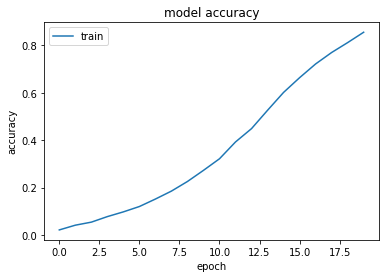

In [31]:
# summarize history for accuracy
plt.plot(model_hist.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


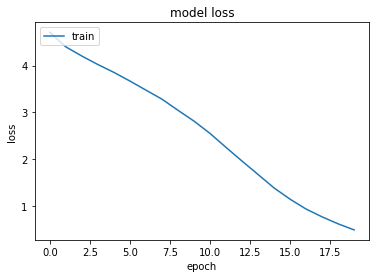

In [32]:
# summarize history for loss
plt.plot(model_hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
submission_data.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,2.839192e-09,3.451655e-04,2.753675e-03,3.877028e-07,8.984754e-06,3.020998e-15,8.416278e-07,1.307453e-06,9.597786e-07,...,3.589998e-06,2.492839e-07,3.069149e-09,7.086798e-07,2.596388e-03,1.226619e-05,1.131287e-05,2.999909e-02,1.451220e-04,1.997639e-07
1,56eef5133aeac23ce93a07e43be7d22f,2.412674e-14,2.326727e-12,1.830225e-10,2.218899e-07,7.018526e-14,3.813891e-18,5.663180e-03,1.462709e-09,2.483815e-07,...,9.356164e-07,1.855845e-06,9.745362e-09,1.103746e-10,1.175196e-07,1.321511e-08,1.092664e-19,1.123342e-08,9.896335e-13,8.559925e-03
2,d6487ec0c82b85e4db6e9b57a69b7587,5.495641e-02,6.314468e-07,3.686154e-04,1.327258e-09,4.173014e-08,1.687474e-09,1.310165e-08,5.193287e-09,1.660111e-07,...,1.570099e-06,1.284374e-06,1.527514e-07,1.120431e-09,4.641067e-01,1.146493e-10,1.219507e-11,3.335257e-06,1.963244e-07,1.834938e-06
3,0eb22da796bce296261373cfc4f3c2c8,2.090162e-12,8.246293e-09,1.332261e-10,2.971562e-10,1.069892e-06,1.858152e-17,1.134135e-08,2.991833e-12,3.952737e-13,...,1.910920e-04,4.512136e-13,1.059952e-12,3.350451e-12,2.925991e-05,4.464807e-11,1.771437e-01,8.648353e-06,3.433820e-06,4.652510e-05
4,230a6fb01dffd20c3f51ac7261ed0c68,5.261115e-06,1.544125e-03,2.365612e-03,1.164066e-04,1.411720e-05,2.644368e-10,4.308083e-02,4.297225e-08,9.603519e-06,...,7.261063e-03,4.885868e-07,3.739473e-06,2.027906e-07,2.394093e-03,3.189786e-08,1.455230e-06,2.416667e-07,3.309084e-04,1.834862e-03
